In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 149M/149M [00:07<00:00, 21.7MB/s]
100% 149M/149M [00:07<00:00, 19.8MB/s]


In [ ]:
!unzip \*.zip && rm*.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/Tr-gl_0732.jpg  
  inflating: Training/glioma/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
%matplotlib inline
import os
import glob as gb
import cv2
import tensorflow  as tf
import keras
from tqdm import tqdm
from collections import Counter
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


In [ ]:
#Generate data paths with labels
train_data_dir = '/content/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# Generate data paths with labels
test_data_dir = '/content/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.2)

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= 32)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= 32)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= 32)

#history = model.fit(x= train_gen, epochs= epochs, batch_size=batch, validation_data= valid_gen)

Found 5712 validated image filenames belonging to 4 classes.
Found 262 validated image filenames belonging to 4 classes.
Found 1049 validated image filenames belonging to 4 classes.


In [ ]:

def create_custom_cnn(image_size, num_classes, optim, lossF, metrics):
    model = tf.keras.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_size))
    model.add(layers.MaxPooling2D((2, 2)))


    # Second convolutional layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))


    # Third convolutional layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))


    # Flatten the output
    model.add(layers.Flatten())

    # Dense layers for classification
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.35))  # Dropout for regularization
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.35))  # Dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optim, loss=lossF, metrics=metrics)

    # Print model summary
    model.summary()


    # Visualize the model
    visualization_path = 'model_visualization.png'
    tf.keras.utils.plot_model(model, to_file=visualization_path, show_shapes=True, show_layer_names=True)

    print(f"Model visualization saved to {visualization_path}")

    return model


In [ ]:
opt = Adam(learning_rate=0.001)
net = create_custom_cnn(img_shape, 4 ,opt,'categorical_crossentropy','accuracy')
history = net.fit(x= train_gen, epochs= 15, batch_size=32, validation_data= valid_gen)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)      

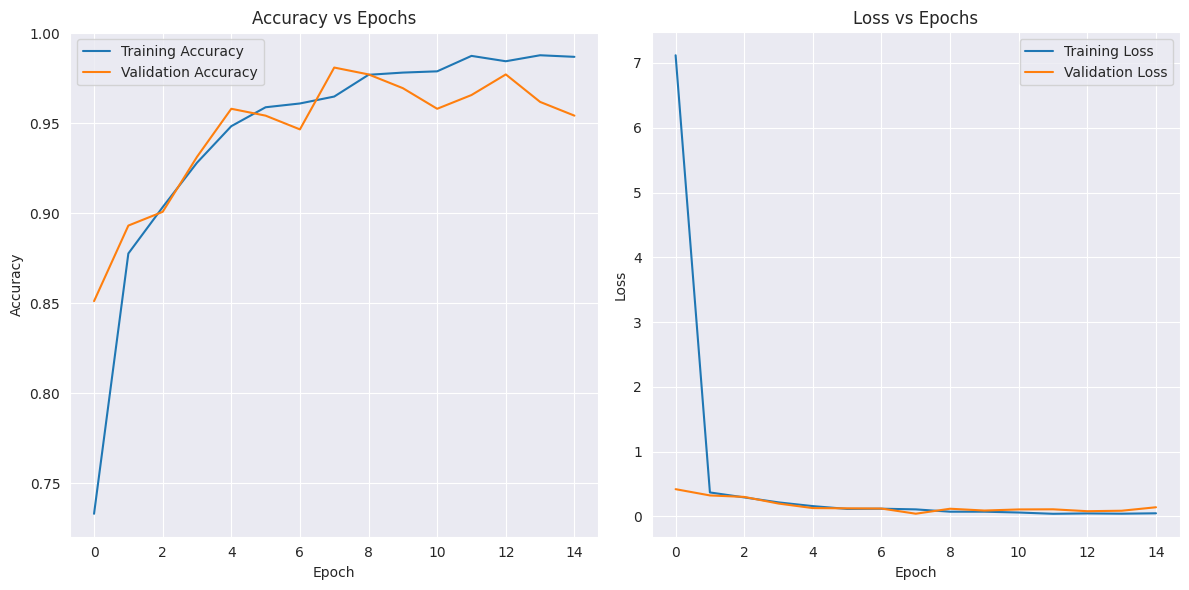

In [ ]:
#Plot accuracy and loss over epochs
plt.figure(figsize=(12, 6))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
net.save("/content/drive/My Drive/ML-Project-Models/CNN_1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loss_functions = [ 'categorical_crossentropy']
results = []
for batch_size in [16, 32, 128]:
    for num_epochs in [15]:
        for lr in [0.0001, 0.001, 0.01]:
            for optimizer_name in [ 'Adam','SGD']:
                for loss_function_name in loss_functions:

                    # Define the optimizer
                    if optimizer_name == 'SGD':
                        optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9)
                    elif optimizer_name == 'Adam':
                        optimizer = optimizers.Adam(learning_rate=lr)

                    net = create_custom_cnn(img_shape, 4 ,optimizer_name,loss_function_name,'accuracy')
                    history2 = net.fit(x= train_gen, epochs= num_epochs, batch_size=batch_size, validation_data= valid_gen)
                    val_acc = history2.history['val_accuracy'][-1]
                    train_acc = history2.history['accuracy'][-1]

                    test_loss, test_acc = net.evaluate(x=test_gen)

                    # Save results
                    results.append({
                        'model': 'CNN',
                        'batch_size': batch_size,
                        'epochs': num_epochs,
                        'optimizer': optimizer_name,
                        'lr': lr,
                        'loss_function': loss_function_name,
                        'val_acc': val_acc,
                        'train_acc':train_acc,
                        'test_acc': test_acc
                    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)



# Save DataFrame to Excel in Colab environment
results_df.to_excel('model_results.xlsx', index=False)

# Download the file
files.download('model_results.xlsx')


print("Results saved to 'model_results.xlsx'")


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 26, 26, 128)      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Results saved to 'model_results.xlsx'


In [ ]:
results_df = pd.DataFrame(results)



# Save DataFrame to Excel in Colab environment
results_df.to_excel('model_results.xlsx', index=False)

# Download the file
files.download('model_results.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print('Validation loss',np.mean(history.history['val_loss']))
print('Training loss',np.mean(history.history['loss']))
print('Validation Accuracy',np.mean(history.history['val_accuracy']))
print('Traing accuracy',np.mean(history.history['accuracy']))

In [ ]:
predictions = single_model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

print(classification_report(y_true, y_pred))
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print('Accuracy:', accuracy_score(y_true, y_pred))
# Print metrics
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

In [ ]:
width=300
height=300
color_channels=3
image_size = (width, height, color_channels)
num_classes = 4  # Adjust based on your specific dataset
#train_path='/content/Training'
#test_path='/content/Testing'
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
final_model_path = '/content/training_1'

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

path_train = ('/content/Training')
path_test = ('/content/Testing')
img_size= 300

for i in os.listdir(path_train):
    for j in os.listdir(path_train+'/'+i):
        x_train.append (cv2.resize(cv2.imread(path_train+'/'+i+'/'+j), (img_size,img_size)))
        y_train.append(i)

for i in os.listdir(path_test):
    for j in os.listdir(path_test+'/'+i):
        x_test.append (cv2.resize(cv2.imread(path_test+'/'+i+'/'+j), (img_size,img_size)))
        y_test.append(i)

x_train = (np.array(x_train))
x_test = (np.array(x_test))



In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f'X_train shape  is {x_train.shape}')
print(f'X_test shape  is {x_test.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')

In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and return encoded labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
y_train_encoded = to_categorical(y_train_encoded,num_classes)
y_test_encoded = to_categorical(y_test_encoded,num_classes)


In [ ]:
print("x_train shape:", x_train.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("x_test shape:", x_test.shape)
print("y_test_encoded shape:", y_test_encoded.shape)


In [ ]:
opt = Adam(learning_rate=0.001)
loss='categorical_crossentropy'
metrics=['accuracy']
single_model = create_custom_cnn(image_size, 4,opt,loss,metrics)

In [ ]:
history = single_model.fit(x_train, y_train_encoded, epochs=15, validation_split=0.2,batch_size = 32)